# Exploratory Review of Forecasting Models and Modeling Pipelines

Code that explores the different LSTM forecasting models for RMS tank level forecasting.

## Load dataset

In [1]:
import warnings
# filter future deprecation warning messages displaying 
warnings.filterwarnings('ignore', category=FutureWarning)
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM



# Error fix TensorFlow Blas GEMM launch failed -- needed for GPU processing
# comment for non-GPU PCs
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Using TensorFlow backend.


In [2]:
# import cleansed dataset
all_devices = pd.read_csv('sap_cleansed_alldevices.csv', parse_dates=['TSTAMP'])

In [3]:
# confirm columns and datatypes
print(all_devices.dtypes)

# confirm dataframe size
all_devices.shape

TSTAMP                 datetime64[ns]
DEVICE_ID                       int64
TempF                         float64
Tank                          float64
Vac                           float64
                            ...      
Tank3PMARateTgt288P           float64
Tank6PMARateTgt288P           float64
FreezeTgt288P.1hr                bool
FreezeTgt288P.1-3hr              bool
FreezeTgt288P.3-6hr              bool
Length: 84, dtype: object


(59501, 84)

In [4]:
# get list of device ids in the dataframe
device_ids = all_devices['DEVICE_ID'].unique()

device_ids

array([ 1,  3,  4,  5,  6,  7,  9, 10, 11], dtype=int64)

In [5]:
# create a dict of dataframes subsetted by the DEVICE_ID to separate each device for analysis
# (using deep copy to eliminate pointer to referenced df)
sap_devices = {}

for ii in device_ids:
    # subset into a df per device
    sap_devices[ii] = all_devices[(all_devices['DEVICE_ID'] == ii)].copy()
    # set index of each df to TSTAMP and sort ascending
    sap_devices[ii] = sap_devices[ii].set_index('TSTAMP').sort_index()

In [6]:
# confirm the number of devices in the df list matches the number of defined devices
len(device_ids) == len(sap_devices)

True

In [7]:
# inspect data for Device 3
sap_devices[3].head(5)

,DEVICE_ID,TempF,Tank,Vac,HourUTC,elapsed_seconds,nonuniform_period,Tank3PMovAvg,Tank6PMovAvg,TankRate,...,FreezeTgt144P.3-6hr,TankTgt288P,Tank3PMATgt288P,Tank6PMATgt288P,TankRateTgt288P,Tank3PMARateTgt288P,Tank6PMARateTgt288P,FreezeTgt288P.1hr,FreezeTgt288P.1-3hr,FreezeTgt288P.3-6hr
TSTAMP,,,,,,,,,,,,,,,,,,,,,
2020-02-22 10:32:51.983,3,68.9,92.9,0.73,10,NaN,False,92.9,92.9,0.0,...,False,11.3,11.566667,11.733333,0.000000,0.000000,0.006557,False,False,False
2020-02-22 10:37:55.983,3,68.9,92.9,0.73,10,304.000,False,92.9,92.9,0.0,...,False,11.7,11.566667,11.700000,0.012645,0.000000,0.006557,False,False,False
2020-02-22 10:42:59.983,3,68.9,92.9,0.72,10,304.000,False,92.9,92.9,0.0,...,False,11.9,11.633333,11.666667,0.025289,0.005528,0.006557,False,False,False
2020-02-22 10:48:03.987,3,68.7,92.9,0.73,10,304.004,False,92.9,92.9,0.0,...,False,11.5,11.700000,11.633333,0.039474,0.011730,0.006557,False,False,False
2020-02-22 10:53:35.007,3,68.7,92.9,0.74,10,331.020,False,92.9,92.9,0.0,...,False,11.5,11.633333,11.600000,0.019737,0.011730,0.006557,True,False,False


## LSTM Model Pipeline

### Define model pipeline functions

In [8]:
# define global forecast evaluation threshold for all models
# only consider actual vs. forecast RMSE for actual tank levels equal or greater than this value
flt_thrsh = 25

# root-mean-squared results function
def rmse_results(actual, predicted, flt_thrsh=0, printout=False):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    # only evaluate predictions for actual values greater or equal to the filter threshold
    filt_thresh = actual >= flt_thrsh
    act = actual[filt_thresh]
    pred = predicted[filt_thresh]
    # evaluate
    mse = mean_squared_error(act,pred)
    rmse = np.sqrt(mse)
    r2score = r2_score(act,pred)
    if printout:
        print(f'Mean squared error on test data: {mse:0.4f}')
        print(f'Root mean squared error on test data: {rmse:0.4f}')
        print(f'R-Squared score on test data: {r2score:0.4f}')        
    return mse, rmse, r2score

  
# function to append to model results dict
def set_device_model_rmse_dict(device_model_rmse_dict, deviceid, model_name, rmse):
    # check if deviceid is already an outer dict key
    if deviceid in device_model_rmse_dict.keys():
        models = device_model_rmse_dict[deviceid]
        # append model score to inner dict
        models[model_name] = rmse
    else: # create inner dict
        models = {}
        models[model_name] = rmse
    # assign or update outer dict key with inner dict
    device_model_rmse_dict[deviceid] = models

    return device_model_rmse_dict


In [9]:
# convert input data to supervised lagged learning features
def transform_input_to_supervised(data, n_lags=1, backfillnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    datacols, varnames = list(), list()
    # input sequence (t-n, ... t-1, t-0)
    for i in range(n_lags, -1, -1):
        datacols.append(df.shift(i))
        varnames += [f'var{j}_(t-{i})' for j in range(n_vars)]
    # put all new datacols together
    newdf = pd.concat(datacols, axis=1)
    newdf.columns = varnames
    # backfill lagged data with NaN
    if backfillnan:
        newdf = newdf.fillna(method='backfill')
    return newdf

In [10]:
# function to convert a dict of forecast dfs into a csv file
def forecastdfs_to_csv(dfs, filesuffix):  
    # combine model forecasts into a single dataframe
    # (using deep copy to eliminate pointer to referenced df)
    # loop through all models in outer key
    for mm in dfs.keys():
        ctr = 0
        # loop through all devices in inner key
        for ii in dfs[mm].keys():
            if ctr == 0:
                all_devices_df = dfs[mm][ii].copy().reset_index()
            else:
                all_devices_df = all_devices_df.append(dfs[mm][ii].copy().reset_index())
            ctr += 1

        file = 'data/' + mm + filesuffix
        all_devices_df.to_csv(file, index=False, header=True)
    
# function to convert csv into a dict of forecast dfs for plotting or other
def forecastcsv_to_dfs(file, device_ids):  
    # parse csv file of forecasts by device into a dict of dfs

    # import dataset
    df = pd.read_csv(file, parse_dates=['TSTAMP'])

    # create a dict of dataframes subsetted by the DEVICE_ID to separate each device for analysis
    # (using deep copy to eliminate pointer to referenced df)
    df_forecasts = {}

    for ii in device_ids:
        # subset into a df per device
        df_forecasts[ii] = df[(df['DEVICE_ID'] == ii)].copy()
        # set index of each df to TSTAMP and sort ascending
        df_forecasts[ii] = df_forecasts[ii].set_index('TSTAMP').sort_index() 
        
    return df_forecasts

In [11]:
# function to build model results column lists for comparison by period
def get_model_result_cols_by_period(period_name_list, models_dict):
    # build list of model results by period
    model_cols = []
    for pp in period_name_list:
        period_cols = [f'{mm}_{pp}' for mm in models_dict]
        model_cols.append(period_cols)
        
    return model_cols


# function to plot model rsme results by forecast period
def plot_model_rmse_results_by_period(model_cols_list, results_df, title):
    
    fig, axs = plt.subplots(ncols=1, nrows=len(model_cols_list), figsize=(16,24))
    fig.suptitle(f'{title}', size = 20, y=1.02)

    # seed subplot row counter
    c = 0
    for rr in range(len(model_cols_list)):
         # create barplots by device and rate column
        (results_df[model_cols_list[rr]]
         .mean()
         .sort_values(ascending=False)
         .plot.barh(rot=0, width= 0.25, ax=axs[rr], xlim=(0,50))
        )

        if c != (len(model_cols_list)-1):
            axs[rr].set_xticklabels([])
            axs[rr].set_xlabel('')
        else:
            axs[rr].set_xlabel('Tank Level Forecast RMSE (%)')
        # incremement subplot row counter
        c += 1

        # title each subplot
    axs[0].set_title('1-Period Forecast (5 mins)')
    axs[1].set_title('6-Period Forecast (30 mins)')
    axs[2].set_title('12-Period Forecast (60 mins)')
    axs[3].set_title('36-Period Forecast (3 hours)')
    axs[4].set_title('72-Period Forecast (6 hours)')                
    axs[5].set_title('144-Period Forecast (12 hours)')
    axs[6].set_title('288-Period Forecast (24 hours)')

    plt.tight_layout()
    
    
# function to plot comparison of tank level actual vs. forecast values
def plot_forecasts_by_device(forecastdf_dict, device_ids_list, threshold_col, actual_cols, forecast_cols, model_name, flt_thrsh=0):
    
    for ii in device_ids_list:
        # take a copy of the dataframe
        df = forecastdf_dict[ii].copy()
        
        # create a series that is a boolean filter of actual values less than threshold
        filt_thresh = df[threshold_col] < flt_thrsh
        
        # set forecast values to nan where the actual value is less than threshold
        df.loc[filt_thresh, forecast_cols] = np.nan
                       
        ( df[actual_cols + forecast_cols]
         .plot(title = f'Device{ii} {model_name} Model Tank Level Actual vs. Forecasted by Period', 
               ylim=(0,100), figsize = (16,4)) )
        



In [12]:
def lstm_training(train_X, train_y, test_X, test_y, hidden_nodes=25, epochs=10, batch_size=32, 
                  verbose=3, plot_fit_loss=False):
    # verbose=0: silent epoch status
    # verbose=1: display detailed epoch status/loss with timing metrics
    # verbose=2: display detailed epoch status/loss
    # verbose=3: display epoch status
    
    # create LSTM
    model = Sequential()
    model.add(LSTM(hidden_nodes, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit LSTM
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, 
                        validation_data=(test_X, test_y), verbose=verbose, shuffle=False)
    # plot epoch fit/loss
    if plot_fit_loss:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
        
    return model


def lstm_test_results(model, scaler, test_X, test_y, flt_thrsh=0):
    
    # make predictions on test inputs
    pred_y = model.predict(test_X)

    #reshape test inputs array to 2-D array and unscale to original scale
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    test_X_unscaled = scaler.inverse_transform(test_X)

    # unscale predictions to original scale
    pred_y_unscaled = scaler.inverse_transform(pred_y)
    # reshape to 1-D array
    pred_y_unscaled = pred_y_unscaled[:, 0]

    # unscale actual targets to original scale
    actual_y_unscaled = scaler.inverse_transform(test_y)
    # reshape to 1-D array
    actual_y_unscaled = actual_y_unscaled[:, 0]
    
    mse, rmse, r2score = rmse_results(actual_y_unscaled, pred_y_unscaled, flt_thrsh=flt_thrsh)
    
    return [mse, rmse, r2score, actual_y_unscaled, pred_y_unscaled]

### LSTM Model Pipeline

In [13]:
%%time

# loop through LSTM models for each device

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]
# dict of model names and parameters (hidden nodes, feature_lags, epochs, batch size)
lstm_models = {'lstm':[25, 6, 10, 32],
              }

pct_test = 0.25
verbose = 0
# verbose=0: silent epoch status
# verbose=1: display detailed epoch status/loss with timing metrics
# verbose=2: display detailed epoch status/loss
# verbose=3: display epoch status

# initialize dict of model results
device_lstm_model_rmse = {}

# initialize dict of forecast results
device_lstm_model_forecasts = {}

# initialize dict of model processing times
device_lstm_model_process_time = {}

for mm in lstm_models:
    print(f'testing model {mm}')
    params = lstm_models[mm]
    
    for ii in device_ids:
        print(f'Processing device{ii}...')
        # store starting time 
        begin = time.time()
        
        df = sap_devices[ii]
        inputs = df[input_cols]
        
        #counts of test data
        n_test = int(len(inputs)*pct_test)

        #initialize dataframe to store actuals and predictions
        #  the initial df is populated with the device id, predicted input, and exog input
        #  add offset of the first forcast period to align with periodtargets
        forecasts_df = df[['DEVICE_ID',input_cols[0],'TempF']][-n_test+periods[0]:]        

        dfs = [forecasts_df] # list of dataframes of forecasts for plotting        
        for cc in range(len(target_cols)):
            # load dataset with n_lagged inputs as features
            dataX = transform_input_to_supervised(inputs, n_lags=params[1])
            dataY = df[target_cols[cc]]
            
            # boolean filter of target values that are not NaN
            filtnan = dataY.notnull()

            # timestamp index of target values            
            indexYtest = dataY[-n_test:].index.to_series()            
            # reset index from datetime to int
            indexYtest = indexYtest.reset_index(drop=True)
                
            # align timestamp index of target value by shifting target timestamps backward
            periodtargetsidx = indexYtest.shift(-periods[cc])
            # filter non-nan index timestamps
            idxfiltnan = periodtargetsidx.notnull()

            # convert to numpy array with NaN dropped
            valuesX = dataX.values[filtnan]
            valuesY = dataY.values[filtnan]
            
            # ensure all data is float
            valuesX = valuesX.astype('float32')
            valuesY = valuesY.astype('float32')

            # normalize features
            scaler = MinMaxScaler(feature_range=(0, 1))

            valuesY = valuesY.reshape(valuesY.shape[0], 1)

            scaledX = scaler.fit_transform(valuesX)
            scaledY = scaler.fit_transform(valuesY)


            # split into train and test
            train_X = scaledX[:-n_test+periods[cc]]
            test_X = scaledX[-n_test+periods[cc]:]
            train_y = scaledY[:-n_test+periods[cc]]
            test_y = scaledY[-n_test+periods[cc]:]

            # reshape input to be 3D [samples, timesteps, features]
            train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
            test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))        


            # process model and get predictions
            print(f'testing model {mm} for {periods[cc]} period forecasts')
            
            model = lstm_training(train_X, train_y, test_X, test_y, hidden_nodes=params[0], 
                                  epochs=params[2], batch_size=params[3], verbose=verbose)

            results = lstm_test_results(model, scaler, test_X, test_y, flt_thrsh=flt_thrsh)

            device_lstm_model_rmse = set_device_model_rmse_dict(device_lstm_model_rmse, f'device{ii}', 
                                                               mm+'_'+period_names[cc], results[1])

            # create dataframe of period forecasts
            df_fcst = pd.DataFrame(data=results[4], index=periodtargetsidx[idxfiltnan], columns=[f'Forecast_{periods[cc]}P'])
            # append to list of period forecasts for the device
            dfs.append(df_fcst)
        
        # store ending time
        end = time.time()
        
        # list of period forecast dfs for a model/device combo
        forecasts_df = pd.concat(dfs, axis=1)
        
        # capture model forecast results across all devices
        # nested forecast dict {ModelName: {deviceX:df, deviceY:df, deviceZ:df}}
        if mm in device_lstm_model_forecasts:
            device_lstm_model_forecasts[mm][ii] = forecasts_df
        else:
            device_lstm_model_forecasts[mm] = {}
            device_lstm_model_forecasts[mm][ii] = forecasts_df
            
        # capture model processing time results
        devicekey = f'device{ii}'
        if devicekey in device_lstm_model_process_time:
            device_lstm_model_process_time[devicekey][mm] = (end - begin)
        else:
            device_lstm_model_process_time[devicekey] = {}
            device_lstm_model_process_time[devicekey][mm] = (end - begin)            


testing model lstm
Processing device1...
testing model lstm for 1 period forecasts
testing model lstm for 6 period forecasts
testing model lstm for 12 period forecasts
testing model lstm for 36 period forecasts
testing model lstm for 72 period forecasts
testing model lstm for 144 period forecasts
testing model lstm for 288 period forecasts
Processing device3...
testing model lstm for 1 period forecasts
testing model lstm for 6 period forecasts
testing model lstm for 12 period forecasts
testing model lstm for 36 period forecasts
testing model lstm for 72 period forecasts
testing model lstm for 144 period forecasts
testing model lstm for 288 period forecasts
Processing device4...
testing model lstm for 1 period forecasts
testing model lstm for 6 period forecasts
testing model lstm for 12 period forecasts
testing model lstm for 36 period forecasts
testing model lstm for 72 period forecasts
testing model lstm for 144 period forecasts
testing model lstm for 288 period forecasts
Processing d

In [14]:
# convert model results dict to a dataframe
device_lstm_model_rmse_df = pd.DataFrame.from_dict(device_lstm_model_rmse, orient='index')

# convert model processing times dict to a dataframe
device_lstm_model_process_time_df = pd.DataFrame.from_dict(device_lstm_model_process_time, orient='index')

# save results to file
device_lstm_model_rmse_df.to_csv('data/lstm_model_results_alldevices.csv', index=True, header=True)
device_lstm_model_process_time_df.to_csv('data/lstm_model_process_time_alldevices.csv', index=True, header=True)

# save forecasts to file
forecastdfs_to_csv(dfs=device_lstm_model_forecasts, filesuffix='_model_forecasts_alldevices.csv')

print('LSTM forecast results:')
device_lstm_model_rmse_df 


LSTM forecast results:


,lstm_1P,lstm_6P,lstm_12P,lstm_36P,lstm_72P,lstm_144P,lstm_288P
device1,3.665053,6.963578,9.892076,16.446682,17.802444,17.737148,15.939660
device3,1.018302,2.423342,3.039748,5.442053,7.320621,9.834987,10.799500
device4,3.197177,5.886438,7.071093,9.983446,12.117464,15.777752,16.995506
device5,2.896544,5.857658,6.368427,7.255610,9.345778,11.683837,9.299220
device6,1.535427,2.292356,2.781881,5.913401,9.716907,14.014977,17.041439
device7,1.864146,6.847878,9.318373,16.997364,22.236881,23.437998,25.850761
device9,2.286011,5.588582,8.477457,19.338007,28.472975,34.844021,38.966789
device10,7.060163,13.763098,20.781590,26.158520,24.209831,24.580791,26.135658
device11,2.025291,4.101562,6.088965,8.945598,11.105669,13.822032,16.028744


### LSTM Model Results

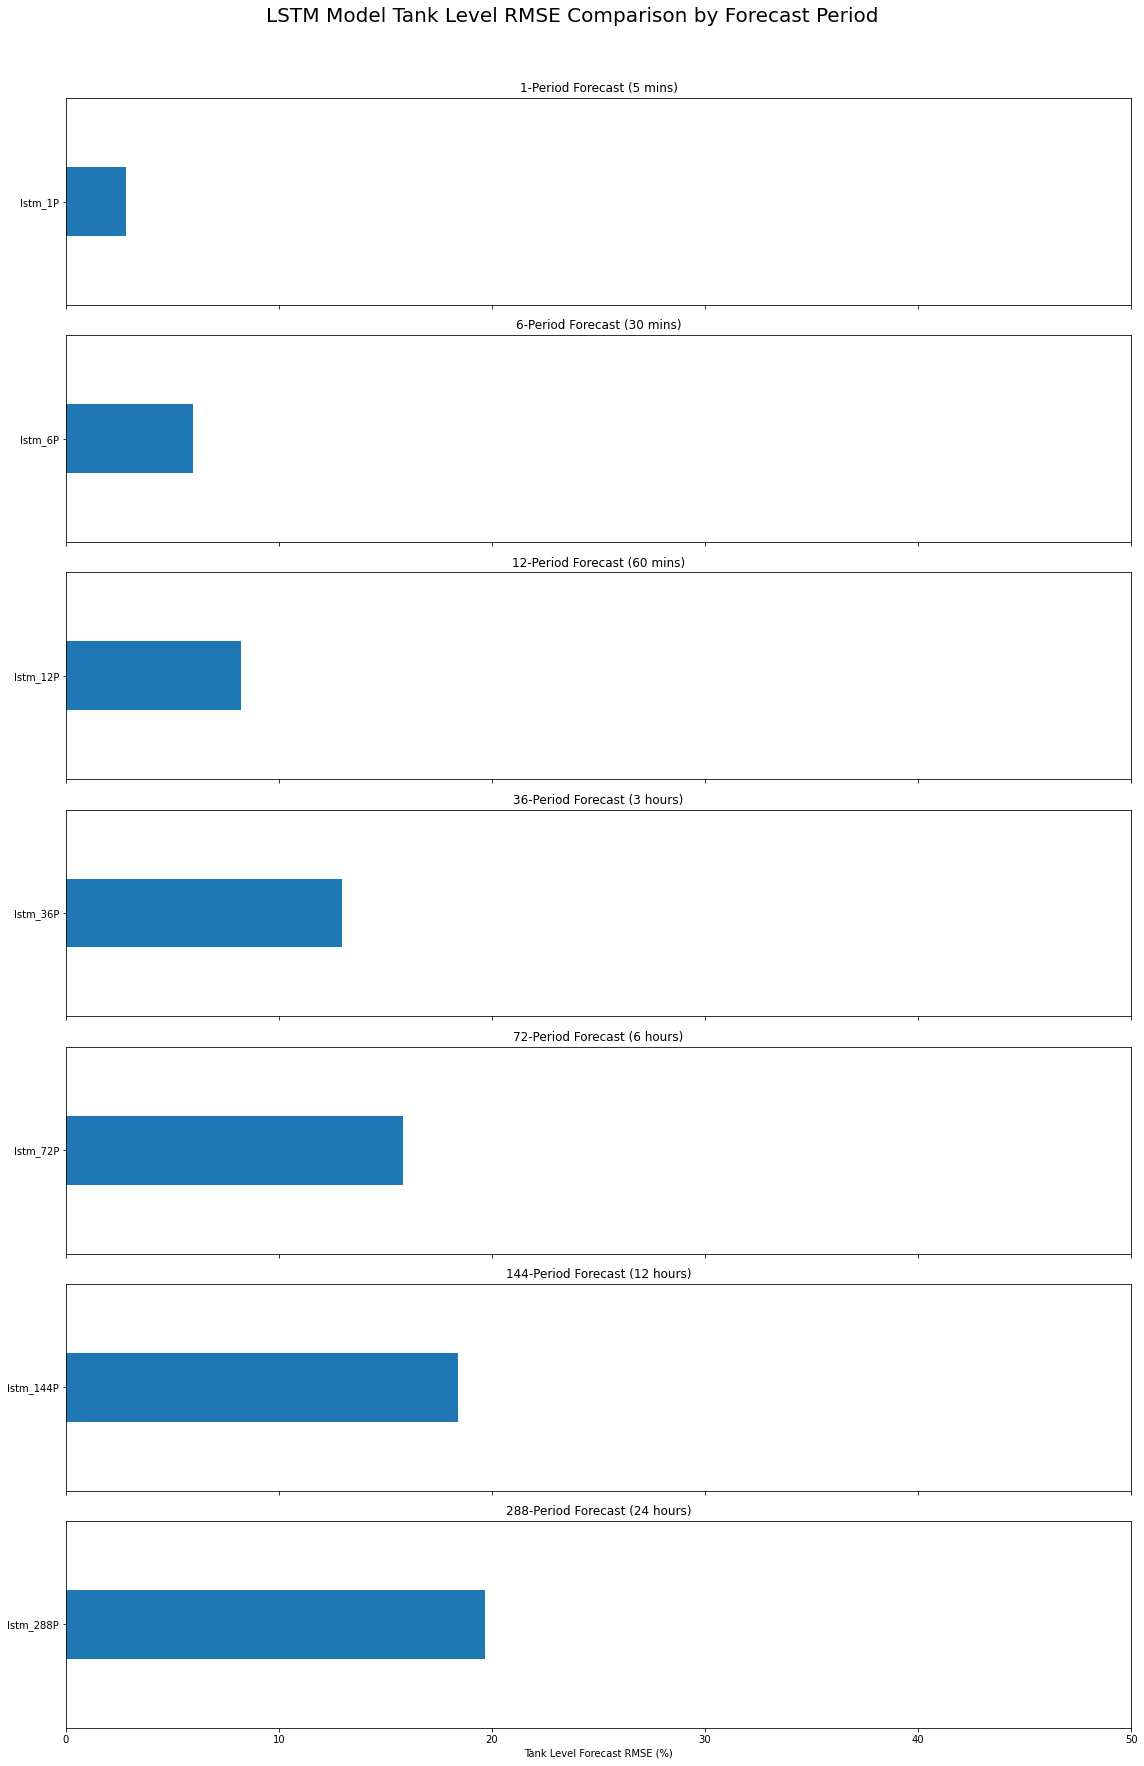

In [15]:
# plot model results
%matplotlib inline

# get model RMSE result period columns list
lstm_model_cols = get_model_result_cols_by_period(period_names, lstm_models)

# plot model RMSE results by forecast period
plot_model_rmse_results_by_period(lstm_model_cols, device_lstm_model_rmse_df, 
                                 'LSTM Model Tank Level RMSE Comparison by Forecast Period')


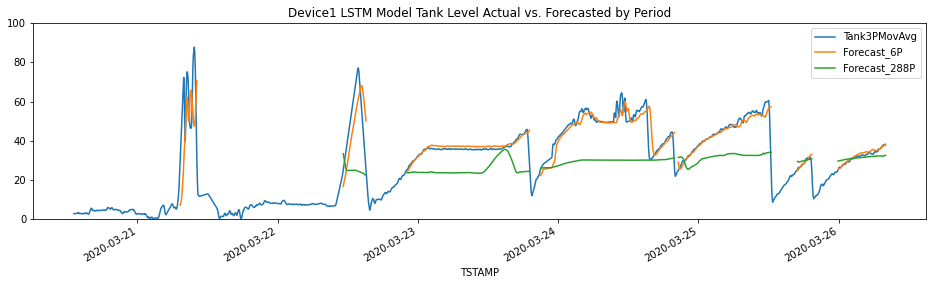

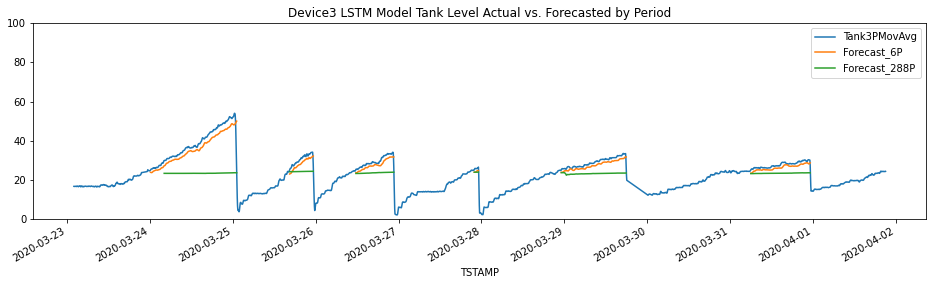

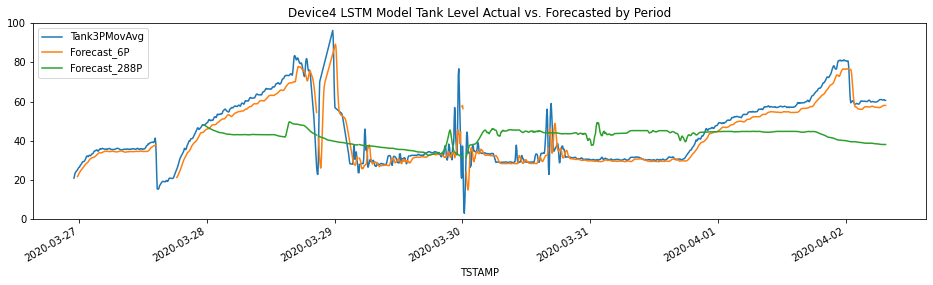

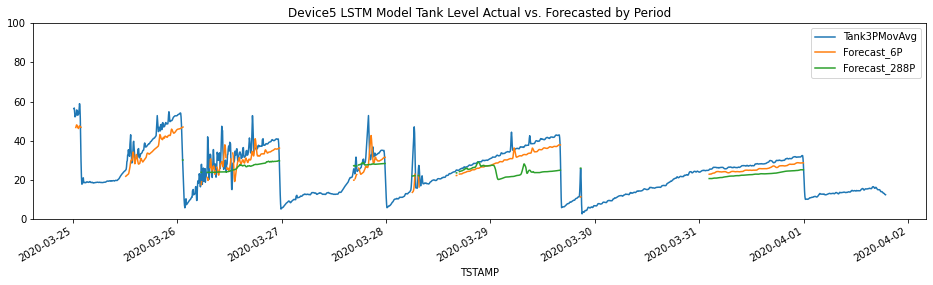

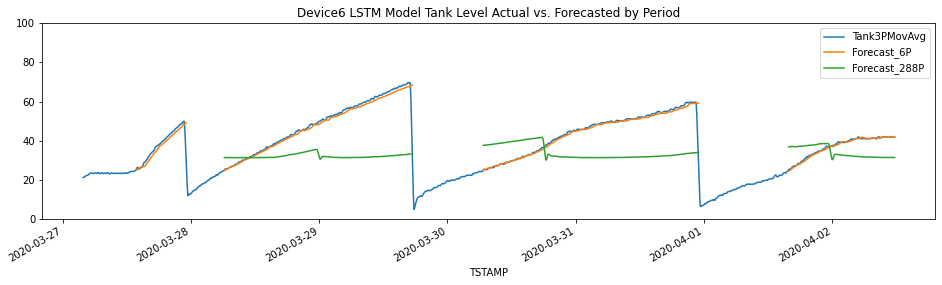

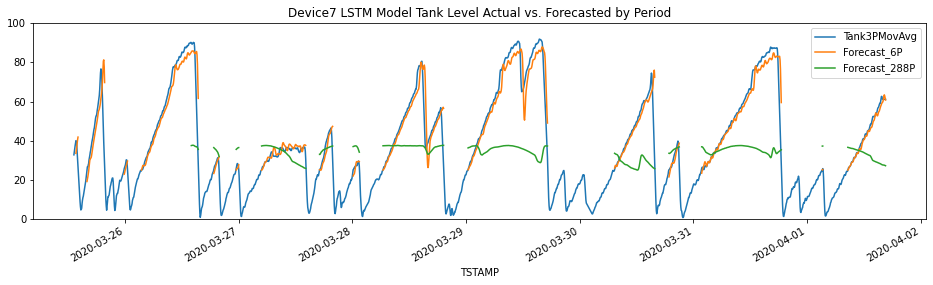

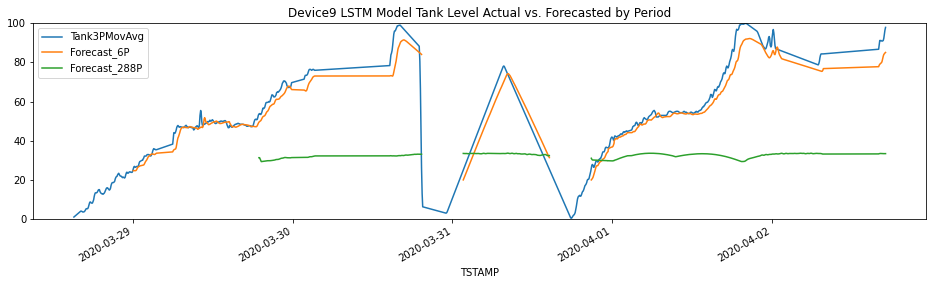

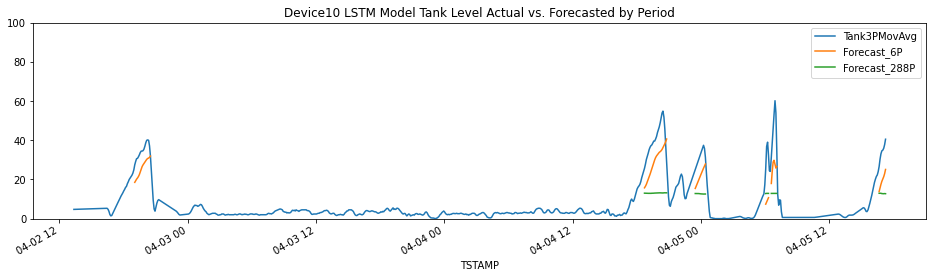

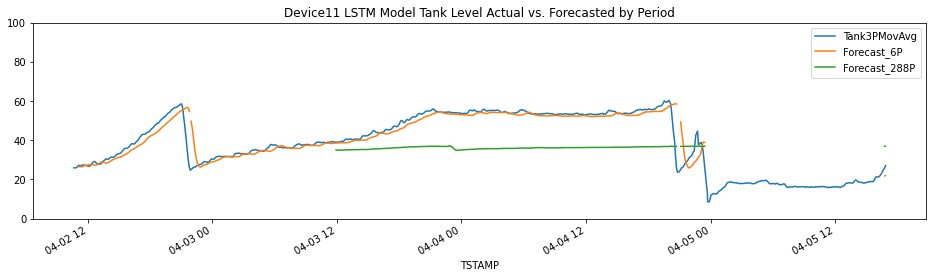

In [16]:
# plot model results
%matplotlib inline

# plot comparison of tank level actual vs. forecast values

# get dfs from forecast file
lstm_forecasts = forecastcsv_to_dfs(file='data/lstm_model_forecasts_alldevices.csv', device_ids=device_ids)

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_6P', 'Forecast_288P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(lstm_forecasts, device_ids, threshhold_col, actual_cols, forecast_cols, 'LSTM', flt_thrsh)



### LSTM with Temp Model Pipeline

In [17]:
%%time

# loop through LSTM models for each device

input_cols = ['Tank3PMovAvg', 'TempF']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]
# dict of model names and parameters (hidden nodes, feature_lags, epochs, batch size)
lstmTemp_models = {'lstmTemp':[25, 6, 10, 32],
              }

pct_test = 0.25
verbose = 0
# verbose=0: silent epoch status
# verbose=1: display detailed epoch status/loss with timing metrics
# verbose=2: display detailed epoch status/loss
# verbose=3: display epoch status

# initialize dict of model results
device_lstmTemp_model_rmse = {}

# initialize dict of forecast results
device_lstmTemp_model_forecasts = {}

# initialize dict of model processing times
device_lstmTemp_model_process_time = {}

for mm in lstmTemp_models:
    print(f'testing model {mm}')
    params = lstmTemp_models[mm]
    
    for ii in device_ids:
        print(f'Processing device{ii}...')

        # store starting time 
        begin = time.time() 
        
        df = sap_devices[ii]
        inputs = df[input_cols]
        
        #counts of test data
        n_test = int(len(inputs)*pct_test)

        #initialize dataframe to store actuals and predictions
        #  the initial df is populated with the device id, predicted input, and exog input
        #  add offset of the first forcast period to align with periodtargets
        forecasts_df = df[['DEVICE_ID',input_cols[0],'TempF']][-n_test+periods[0]:]        

        dfs = [forecasts_df] # list of dataframes of forecasts for plotting        
        for cc in range(len(target_cols)):
            # load dataset with n_lagged inputs as features
            dataX = transform_input_to_supervised(inputs, n_lags=params[1])
            dataY = df[target_cols[cc]]
            
            # boolean filter of target values that are not NaN
            filtnan = dataY.notnull()

            # timestamp index of target values            
            indexYtest = dataY[-n_test:].index.to_series()            
            # reset index from datetime to int
            indexYtest = indexYtest.reset_index(drop=True)
                
            # align timestamp index of target value by shifting target timestamps backward
            periodtargetsidx = indexYtest.shift(-periods[cc])
            # filter non-nan index timestamps
            idxfiltnan = periodtargetsidx.notnull()

            # convert to numpy array with NaN dropped
            valuesX = dataX.values[filtnan]
            valuesY = dataY.values[filtnan]
            
            # ensure all data is float
            valuesX = valuesX.astype('float32')
            valuesY = valuesY.astype('float32')

            # normalize features
            scaler = MinMaxScaler(feature_range=(0, 1))

            valuesY = valuesY.reshape(valuesY.shape[0], 1)

            scaledX = scaler.fit_transform(valuesX)
            scaledY = scaler.fit_transform(valuesY)


            # split into train and test
            train_X = scaledX[:-n_test+periods[cc]]
            test_X = scaledX[-n_test+periods[cc]:]
            train_y = scaledY[:-n_test+periods[cc]]
            test_y = scaledY[-n_test+periods[cc]:]

            # reshape input to be 3D [samples, timesteps, features]
            train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
            test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))        


            # process model and get predictions
            print(f'testing model {mm} for {periods[cc]} period forecasts')
            model = lstm_training(train_X, train_y, test_X, test_y, hidden_nodes=params[0], 
                                  epochs=params[2], batch_size=params[3], verbose=verbose)

            results = lstm_test_results(model, scaler, test_X, test_y, flt_thrsh)

            device_lstmTemp_model_rmse = set_device_model_rmse_dict(device_lstmTemp_model_rmse, f'device{ii}', 
                                                               mm+'_'+period_names[cc], results[1])

            # create dataframe of period forecasts
            df_fcst = pd.DataFrame(data=results[4], index=periodtargetsidx[idxfiltnan], columns=[f'Forecast_{periods[cc]}P'])
            # append to list of period forecasts for the device
            dfs.append(df_fcst)
        
        # store ending time
        end = time.time()
        
        # list of period forecast dfs for a model/device combo
        forecasts_df = pd.concat(dfs, axis=1)
        
        # capture model forecast results across all devices
        # nested forecast dict {ModelName: {deviceX:df, deviceY:df, deviceZ:df}}
        if mm in device_lstmTemp_model_forecasts:
            device_lstmTemp_model_forecasts[mm][ii] = forecasts_df
        else:
            device_lstmTemp_model_forecasts[mm] = {}
            device_lstmTemp_model_forecasts[mm][ii] = forecasts_df
            
        # capture model processing time results
        devicekey = f'device{ii}'
        if devicekey in device_lstmTemp_model_process_time:
            device_lstmTemp_model_process_time[devicekey][mm] = (end - begin)
        else:
            device_lstmTemp_model_process_time[devicekey] = {}
            device_lstmTemp_model_process_time[devicekey][mm] = (end - begin)            


testing model lstmTemp
Processing device1...
testing model lstmTemp for 1 period forecasts
testing model lstmTemp for 6 period forecasts
testing model lstmTemp for 12 period forecasts
testing model lstmTemp for 36 period forecasts
testing model lstmTemp for 72 period forecasts
testing model lstmTemp for 144 period forecasts
testing model lstmTemp for 288 period forecasts
Processing device3...
testing model lstmTemp for 1 period forecasts
testing model lstmTemp for 6 period forecasts
testing model lstmTemp for 12 period forecasts
testing model lstmTemp for 36 period forecasts
testing model lstmTemp for 72 period forecasts
testing model lstmTemp for 144 period forecasts
testing model lstmTemp for 288 period forecasts
Processing device4...
testing model lstmTemp for 1 period forecasts
testing model lstmTemp for 6 period forecasts
testing model lstmTemp for 12 period forecasts
testing model lstmTemp for 36 period forecasts
testing model lstmTemp for 72 period forecasts
testing model lstmTe

In [18]:
# convert model results dict to a dataframe
device_lstmTemp_model_rmse_df = pd.DataFrame.from_dict(device_lstmTemp_model_rmse, orient='index')

# convert model processing times dict to a dataframe
device_lstmTemp_model_process_time_df = pd.DataFrame.from_dict(device_lstmTemp_model_process_time, orient='index')

# save results to file
device_lstmTemp_model_rmse_df.to_csv('data/lstmtemp_model_results_alldevices.csv', index=True, header=True)
device_lstmTemp_model_process_time_df.to_csv('data/lstmTemp_model_process_time_alldevices.csv', index=True, header=True)

# save forecasts to file
forecastdfs_to_csv(dfs=device_lstmTemp_model_forecasts, filesuffix='_model_forecasts_alldevices.csv')

print('LSTM with Temp forecast results:')
device_lstmTemp_model_rmse_df 

LSTM with Temp forecast results:


,lstmTemp_1P,lstmTemp_6P,lstmTemp_12P,lstmTemp_36P,lstmTemp_72P,lstmTemp_144P,lstmTemp_288P
device1,4.214964,7.533115,10.173289,16.528828,18.067823,18.010672,17.017380
device3,0.925839,2.063965,2.569311,4.907081,7.625078,9.377609,9.992807
device4,3.313080,6.398118,7.608739,10.181505,12.474206,15.418006,16.959412
device5,2.374565,4.882843,6.590161,8.600882,11.077832,13.343788,9.269191
device6,1.534097,2.394511,2.503026,4.998406,9.437466,13.486003,15.797753
device7,2.242905,6.810689,9.720142,18.132957,22.889526,22.394190,26.238403
device9,2.332569,6.113114,9.574882,18.624849,27.155296,34.581264,36.364006
device10,6.288476,15.345236,21.028088,24.156923,24.834774,25.209200,26.694530
device11,2.946736,4.813746,7.322792,10.124914,16.676035,13.269281,18.779114


### LSTM with Temp Model Results

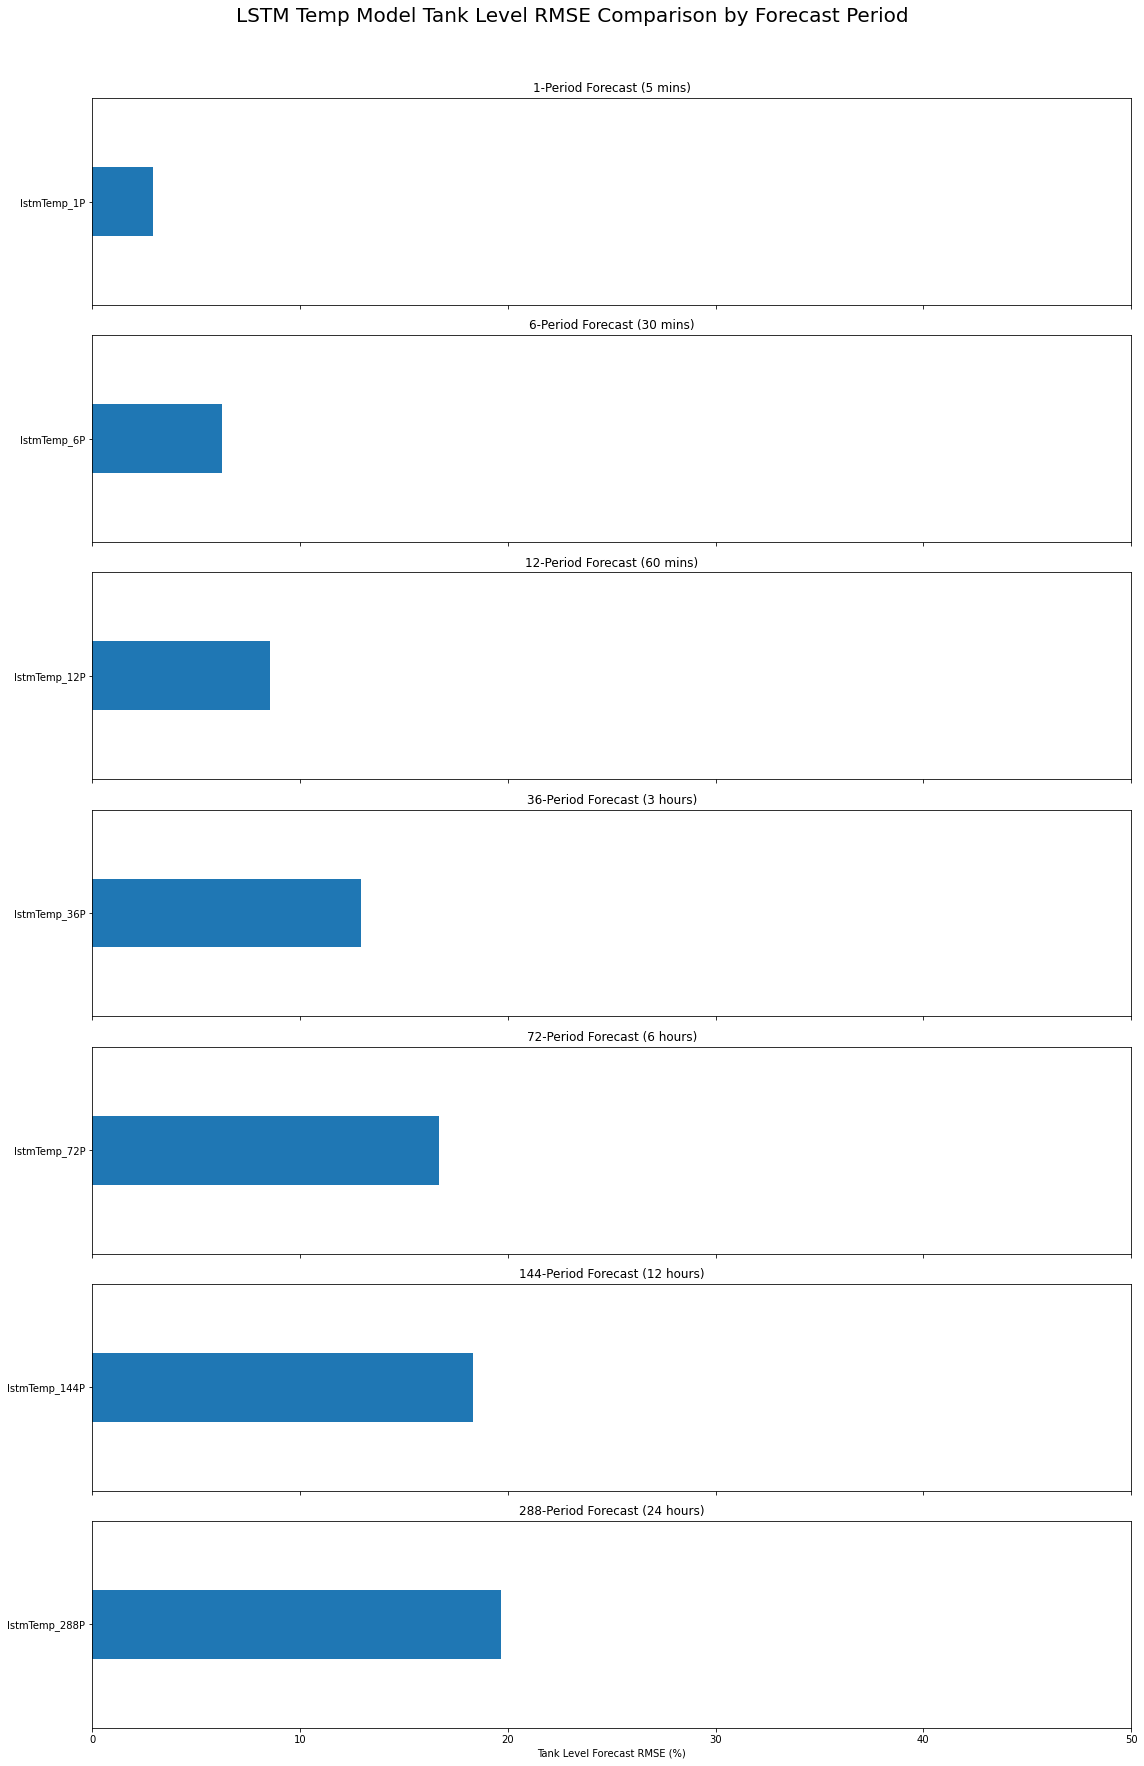

In [19]:
# plot model results
%matplotlib inline

# get model RMSE result period columns list
lstmTemp_model_cols = get_model_result_cols_by_period(period_names, lstmTemp_models)

# plot model RMSE results by forecast period
plot_model_rmse_results_by_period(lstmTemp_model_cols, device_lstmTemp_model_rmse_df, 
                                 'LSTM Temp Model Tank Level RMSE Comparison by Forecast Period')

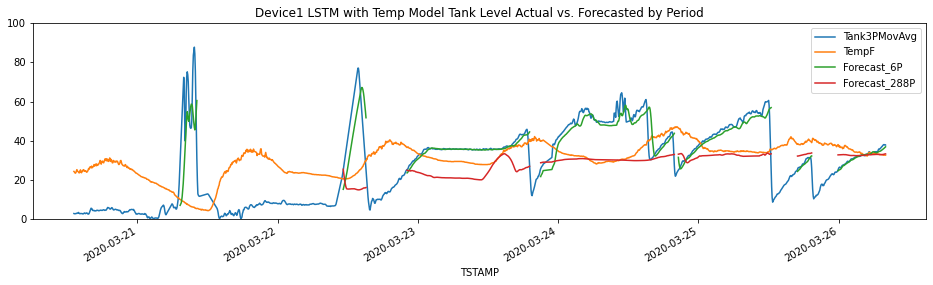

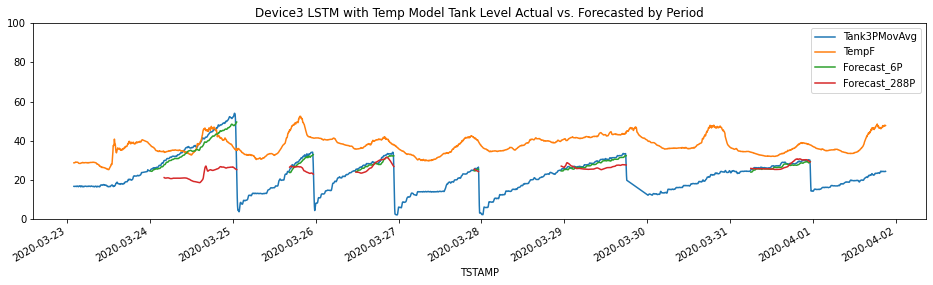

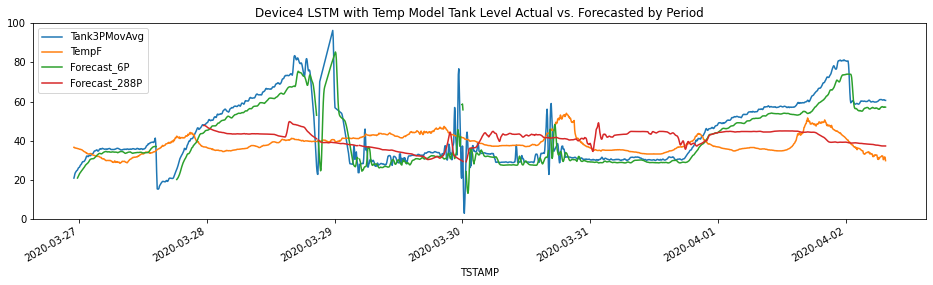

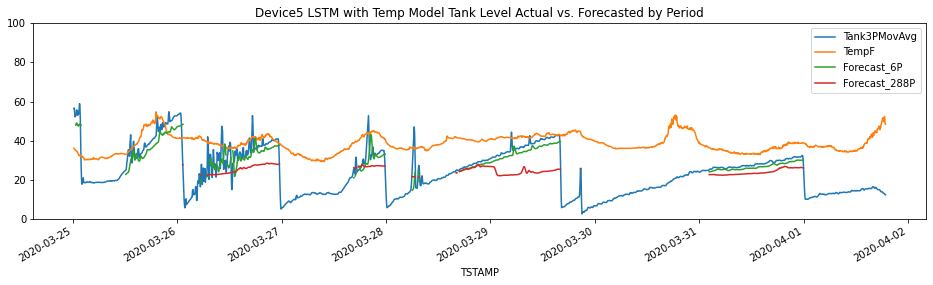

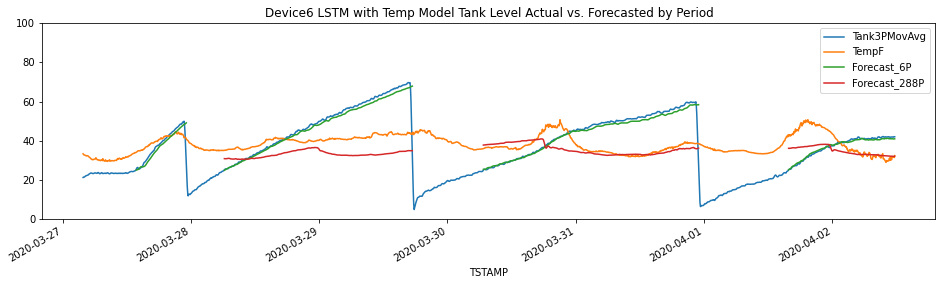

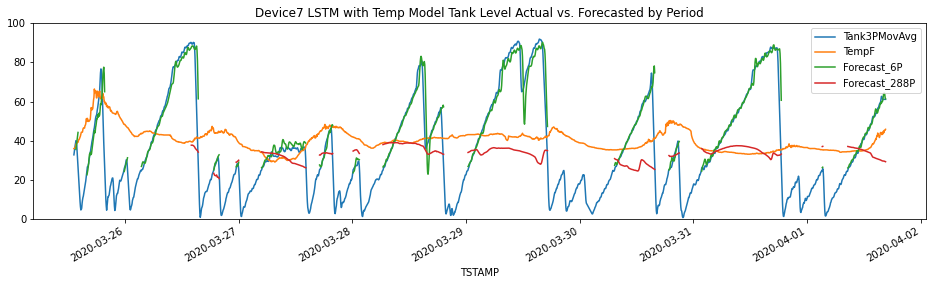

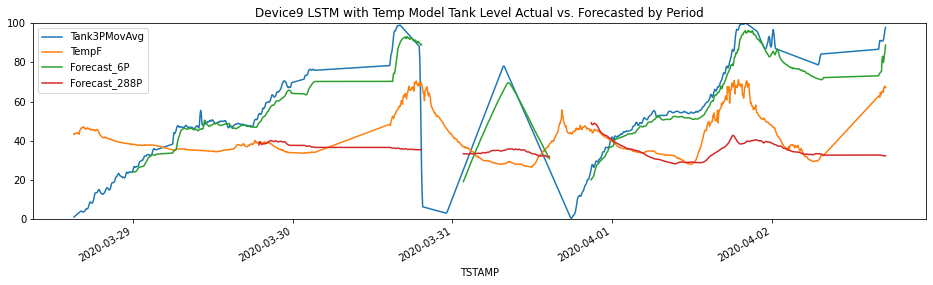

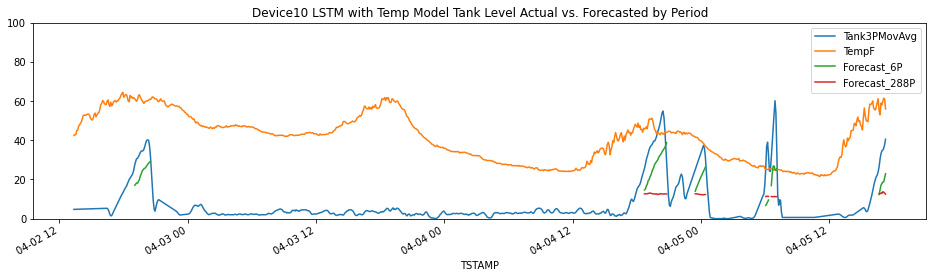

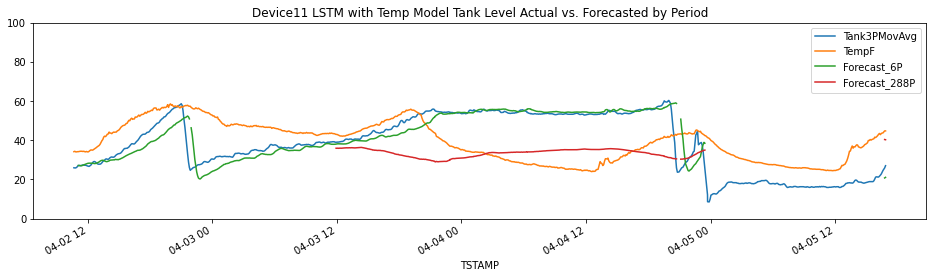

In [20]:
# plot model results
%matplotlib inline

# plot comparison of tank level actual vs. forecast values

# get dfs from forecast file
lstmTemp_forecasts = forecastcsv_to_dfs(file='data/lstmTemp_model_forecasts_alldevices.csv', device_ids=device_ids)

actual_cols = ['Tank3PMovAvg', 'TempF']
forecast_cols = ['Forecast_6P', 'Forecast_288P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(lstmTemp_forecasts, device_ids, threshhold_col, actual_cols, forecast_cols, 'LSTM with Temp', flt_thrsh)